## NEURAL NETWORKS AND DEEP LEARNING A.A. 2021/22

### Samuele Pio Lipani 2025168

### Homework 1 - Supervised Deep Learning

### General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of handwritten digits (MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.


### Regression task

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

#### Dataset 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Loading the data from the csv into a pandas dataframe 

In [2]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

In order to get a specific sample from the data set it can be simply done with the following code

In [3]:
sample_index = 12 # the 13th point into the training dataset 
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 12
INPUT: -4.220851934316842
LABEL: 1.638661820234678


Training points can be plotted ina 2d graph

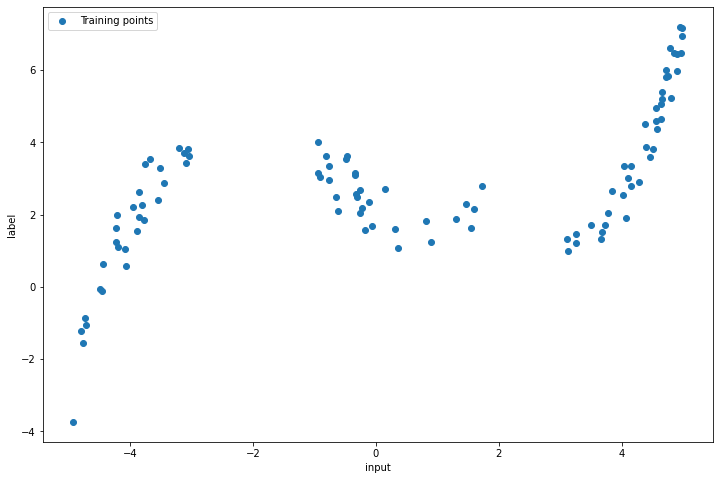

In [4]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

First of all let's import all the needed functions 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, SequentialSampler, ConcatDataset, Subset
from torch.autograd import Variable
from sklearn.model_selection import KFold
from torchvision import transforms
from tqdm import tqdm   
from scipy.stats import loguniform 
from IPython.display import clear_output

First setting 

In [6]:
# in order to get the same results for reproducibility a seed can be set 
seed = 1999
np.random.seed(seed)
torch.manual_seed(seed)

# For speeding calculations GPU can be used but first it has to be verified its availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU NOT available")

GPU available


Another way but more general to load the dataset is by creating a particular class with all the main properties for counting objects and selecting them. 

In [7]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.data = pd.read_csv(csv_file)
        self.valuecol = list(self.data['input'])
        self.labelcol = list(self.data['label'])

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # since dataset csv is composed by two columns, input and label, it is useful to write them into a tuple:
        # sample = (self.data.iloc[idx][self.cols[0]], self.data.iloc[idx][self.cols[1]])
        sample = (self.valuecol[idx], self.labelcol[idx])
        if self.transform:
            sample = self.transform(sample)
        return sample


class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

Now in order to define a network it's necessary to create a class that pytorch can interface with. For the regression task it's better to use a lower number of hidden layers and units for the purpose of not increasing the parameters complexity and trying not to overfit data with a complex model. In this case data are just tuples $D=\{(x_i,y_i)\}_{i=1 \dots N}$ where $N$ is the length of the dataframe and $x_i,y_i$ are samples with the correspondant labels. 

##### Network architecture 
Network will be then composed of:
- Input layer of one neuron 
- A hidden layer with $N_h$ neurons
- A second hidden layer with $2\cdot N_h$ neurons
- An output layer of one neuron

This simple topology in the network is due to the fact that this problem is "simple" from the neural networks point of view, and adding too many parameters we will be easily led to overfitting.
It's important to notice that both input and output layer are made of one neuron. It happens because input both for training and validaton/test should be just the samples $x_i$ sequentially and the output is just the prediction of the network for that particular sample, meaning the labels $y_i$.

In [8]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, drop=0.2):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        drop - dropout parameter removes probabilistically a certain number of neurons from the first hidden layer
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.drop1 = nn.Dropout(p=drop)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.ReLU()

        print('Network initialized')
        # network definition with just its architecture  
        
    def forward(self, x, additional_out = -1):
        x1 = self.act(self.fc1( x ))
        x1 = self.drop1( x1 )
        x2 = self.act(self.fc2(x1))
        x2 = self.drop1( x2 )
        out = self.out( x2 )
        x = [x1, x2]
        
        if additional_out != -1:
            return out, x[additional_out]
        return out
        # in order of propagate information inside the network it's necessary the forward step that makes the layers 
        # acting on the samples
    
    def train_step(self, train_data, optimizer, loss_fn, device):
        """
        Train the @self on dataloader @train_data with a given loss function and an optimizer.
        The function gives back the mean of the loss over different batches and its 
        standard deviation
        """
        # enabling training 
        self.train()
        # training step

        train_loss = []
        for sample_batched in train_data:
            # let's split data into values and lables and move them to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = self.forward(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Backpropagation
            self.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
            
        return train_loss
    
    def eval_step(self, val_data, loss_fn, device):
        """
        Validate/testing  @self on dataloader @val_data given a loss function and the chosen optimizer.
        The function returns the mean of validation loss over batches and its std deviation
        """
        val_loss = []
        # Evaluation mode (e.g. disable dropout)
        self.eval() 

        # Disable gradient tracking
        with torch.no_grad(): 
            for sample_batched in val_data:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)
                # Forward pass
                out = self.forward(x_batch)
                # Compute loss
                loss = loss_fn(out, label_batch)
                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

        return val_loss
    
    def fit(self, train_data, val_data, optimizer, loss_fn, dic_params):
        """
        Training procedure for @self on the data @dataset
        Arguments of the function:
            self (Net)          : Neural network model
            train_data          : Dataloader of train set
            val_data            : Dataloader of validation set
            optimizer           : optimizer for gradient descent
            loss_fn             : loss function 
            dic_params (dict)   : Contains all the parameters
        """

        train_loss_seq = []
        val_loss_seq = []

        for epoch in tqdm(range(dic_params['n_epochs'])):
            # training step 
            train_loss = self.train_step(train_data, optimizer, loss_fn,  dic_params['device'])
            train_loss = np.mean(train_loss)
            # train average loss is saved in order to get at the end a sequance of averages over batches
            train_loss_seq.append(train_loss)
            # VALIDATION
            val_loss = self.eval_step(val_data, loss_fn,  dic_params['device'])
            val_loss = np.mean(val_loss)
            val_loss_seq.append(val_loss)
            
        return train_loss_seq, val_loss_seq
                
                    
    def test(self, test_loader, device, loss_fn):
        """
        Test @self on dataloader @test_loader and returns accuracy
        """
        accuracy = []
        self.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in tqdm(test_loader):
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1][0].to(device)
                # Forward pass
                out = self.forward(x_batch)
                loss = loss_fn(out, label_batch)
                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                # Save val loss for this batch
                accuracy.append( loss_batch.mean() )
        return np.array(accuracy).mean()
    
    # the result network can be saved in memory and it can be loaded back into the pytorch structure 

    def save_net(self, path):
        torch.save(self.state_dict(), path)
        
    def load_net(self, path):
        self.load_state_dict(torch.load(path))


Choice of parameters: 

From now on for the purpose of regularization the activation function between layers has been chosen equal to RElu in order to avoid any gradient vanishing problems, as well as to decrease the computational effort with respect to other choices of activation functions (e.g Sigmoid). Concerning loss function MSEloss has been used and a L2 regularization term is added for avoiding network weights to take too large values. Eventually dropout is also implementes since it makes possible to random eliminate neurons during the training with probability $p_{drop}$.

Two different optimizers will also be tried:
1. The stochastic gradient descent with momentum, which is the really basic algorithm for
optimization. The addition of the momentum, i.e. the memory of previous steps, really helps
to go out of local minima and speeds up convergence;
2. the Adam algorithm, adaptive moment estimator, a more advanced algorithm that uses
estimations of first and second moments of the gradient to adapt the learning rate of each
weight of the neural network

Look if everything works well till now:

In [24]:
# Define the loss function
regr_loss_try = nn.MSELoss()

# define the composition of transformations that should be applied on data  
composed_transform = transforms.Compose([ToTensor()])

# Import train and test datasets and convert elements to tensors
train_data = CsvDataset('regression_dataset/train_data.csv', transform = composed_transform)
test_data = CsvDataset('regression_dataset/test_data.csv', transform = composed_transform)

# let's define a network architecture and train and test it for a random optimizer 
netw = Net(1,15,20,1, 0.2)
netw.to(device)

rand_optimizer = optim.Adam(netw.parameters(), lr=1e-3)

# now the actual training 
params = dict({'optimizer': rand_optimizer,
               'n_epochs': 200,
               'device': device})

train_try, test_try = netw.fit(train_data, test_data, 
                               params['optimizer'], regr_loss_try, params)

There are 100 training points
A random training point is (tensor([-4.0835]), tensor([1.0461]))
Network initialized


Net(
  (fc1): Linear(in_features=1, out_features=15, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=15, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=1, bias=True)
  (act): ReLU()
)

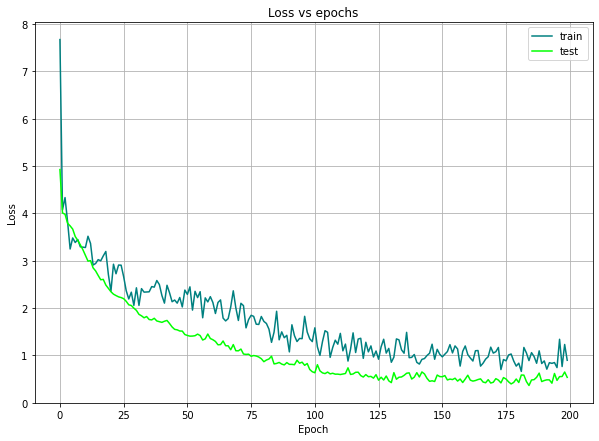

In [61]:
plt.figure(figsize = (10,7))
plt.plot(train_try, label = 'train', color = "teal")
plt.plot(test_try, label = 'test', color = "lime")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs epochs')
plt.legend()
plt.grid()
plt.show()

Here a random optimizer, Adam, with a fixed number of epochs and parameters for the network architecture are used. This dummy example already shows that, even without parameters estimation, test error is lower than training meaning that the neural networks does not behave well because of its complexity or predictions are just easier than training data.
Even if hyperparameters tuning was not performed for this example, it is clear that the number of units in the first and second hidden layer should be small in order to reduce network architecture complexity.

#### Parameters tuning: grid search and cross validation
Since the amount of data is few for this task it is useful to apply a cross validation tecnique for performing hyper parameters tuning. The procedure consists in splitting the training set into $k$ disjoint folds and then training the network on the union of $k-1$ folds performing the validation on the one which is missing. This approach ensures better perfomances since the validation test is different for each iteration therefore the result network should not overfit any of the validation sets. After the best set of parameters is chosen the network will be trained on them over the full training set in order to see its real performances and accuracy. Parameters to be optimized are the number of units in the hidden layers, the learning rate and the number of epochs needed for training.   

In [80]:
def split_folds(dataset, n_folds=4):
    """
    Arguments:
    @dataset are data with values and lables 
    @n_folds is the number of folds data will be splitted in
    """
    num_data = len(dataset)
    # len_folds = num_data//num_folds
    limits = np.linspace(0, num_data, n_folds + 1, dtype = int)
    # from there i can split data by following limits of this array 
    indices_folds = [np.arange(limits[i-1],limits[i]) for i in range(1, n_folds + 1)]
    # now i can subset data given indices i have created
    folds = [Subset(dataset, indices_folds[i]) for i in range(n_folds)]
    return folds

def CrossValidation(params, dataset, n_folds=4, N=1):
    # outputs of the function
    params_f = []
    train_loss_seq = []
    val_loss_seq = []
    # Loss function
    loss = nn.MSELoss() 
    folds = split_folds(dataset, n_folds=n_folds)
    for i in range(N):
        for j, f in enumerate(folds):
            # Preparing data
            valid_load = DataLoader(f, batch_size=20, 
                                    shuffle=False, num_workers=0 )
            training_set = folds[:j]+folds[j+1:]
            training_set = ConcatDataset(training_set)
            training_load = DataLoader(training_set, batch_size=20, 
                                    shuffle=True, num_workers=0 )
            # Random parameter selection
            par_t = sampling(params)
            params_f.append(par_t)
            # Initialization of the net
            Ni, Nh1, Nh2, No = 1, par_t['Nh'], 2*par_t['Nh'], 1
            net = Net(Ni, Nh1, Nh2, No, par_t['drop']).to(par_t['device'])
            # Initialization of the optimizer
            if par_t['optimizer']=='adam':
                opt = optim.Adam(net.parameters(), lr=par_t['learning_rate'], 
                                 weight_decay=par_t['regularization'])
            elif par_t['optimizer']=='sgd':
                opt = optim.SGD(net.parameters(), lr=par_t['learning_rate'], momentum=0.9,
                               weight_decay=par_t['regularization'])
                               
            # Training & validation
            train_loss, val_loss = net.fit(training_load, valid_load, opt, loss, par_t)
            
            # Storing train/loss validation
            train_loss_seq.append(train_loss)
            val_loss_seq.append(val_loss)
    return params_f, train_loss_seq, val_loss_seq

grid_params = {  
            "device"           : [device],
            "drop"             : np.random.uniform(0, 0.4, 1000),
            "n_epochs"         : [100, 200, 300],
            "learning_rate"    : loguniform.rvs(1e-4, 1e-2, size=100),
            "optimizer"        : ['sgd', 'adam'],
            "regularization"   : loguniform.rvs(1e-5, 1e-3, size=1000),
            "Nh"               : [10, 20, 40]
         }

def sampling(params):
    sampled = {}
    for i in params.keys():
        sampled[i] = np.random.choice(params[i])
    return sampled

Cross validation function takes as arguments the grid of parameters we want to exploit for investigating the best setting for the network, training data composed of values and labels, number of folds and the number of iterations the validation fold should be changed. In this case this number of iterations is five in order to ensure that with four folds all validation sets would have been used.

In [82]:
params, train_log, val_log = CrossValidation(grid_params, train_data, n_folds=4, N=5)

Network initialized


100%|██████████| 200/200 [00:01<00:00, 109.96it/s]


Network initialized


100%|██████████| 300/300 [00:02<00:00, 129.65it/s]


Network initialized


100%|██████████| 300/300 [00:02<00:00, 124.10it/s]


Network initialized


100%|██████████| 100/100 [00:00<00:00, 146.70it/s]


Network initialized


100%|██████████| 100/100 [00:00<00:00, 128.82it/s]


Network initialized


100%|██████████| 100/100 [00:00<00:00, 108.78it/s]


Network initialized


100%|██████████| 200/200 [00:01<00:00, 114.32it/s]


Network initialized


100%|██████████| 300/300 [00:02<00:00, 118.50it/s]


Network initialized


100%|██████████| 300/300 [00:02<00:00, 116.77it/s]


Network initialized


100%|██████████| 100/100 [00:00<00:00, 133.12it/s]


Network initialized


100%|██████████| 100/100 [00:00<00:00, 115.28it/s]


Network initialized


100%|██████████| 300/300 [00:02<00:00, 135.88it/s]


Network initialized


100%|██████████| 100/100 [00:00<00:00, 115.04it/s]


Network initialized


100%|██████████| 100/100 [00:00<00:00, 134.53it/s]


Network initialized


100%|██████████| 100/100 [00:00<00:00, 135.15it/s]


Network initialized


100%|██████████| 100/100 [00:00<00:00, 108.78it/s]


Network initialized


100%|██████████| 100/100 [00:00<00:00, 123.52it/s]


Network initialized


100%|██████████| 100/100 [00:00<00:00, 117.23it/s]


Network initialized


100%|██████████| 300/300 [00:02<00:00, 114.78it/s]


Network initialized


100%|██████████| 200/200 [00:01<00:00, 117.04it/s]


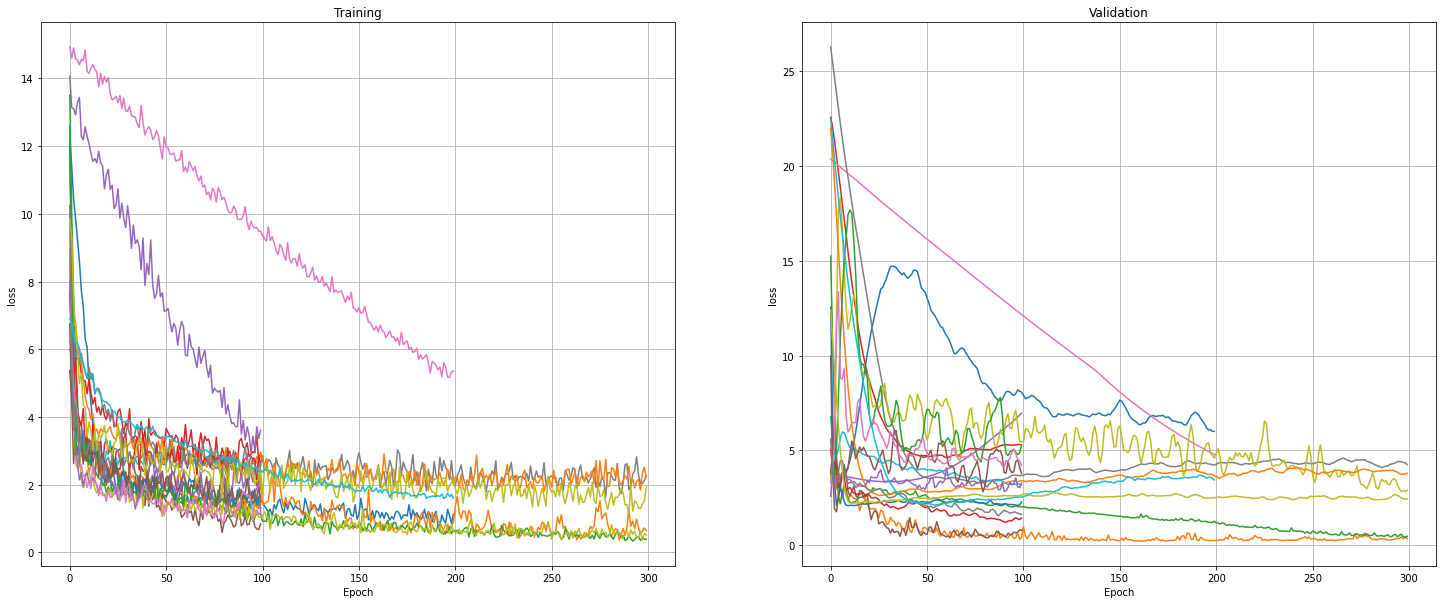

In [96]:
# plotting for each set of parameters, in total twenty, the training and validation time sequence wrt to the epoch 

fig, ax = plt.subplots(1, 2, figsize=(25,10))
for i, trainp in enumerate(train_log):
    ax[0].plot(trainp)
ax[0].set_ylabel('loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Training')
ax[0].grid()

for i, valp in enumerate(val_log):
    ax[1].plot(valp)
ax[1].set_ylabel('loss')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Validation')
ax[1].grid()

In [30]:
def find_best_params(dic_params, loss):
    index = np.argmin([v[-1] for v in loss])
    return dic_params[index]

Best network parameters found are 
 {'device': device(type='cuda'), 'drop': 0.05005672037656055, 'n_epochs': 300, 'learning_rate': 0.0028472667843708593, 'optimizer': 'sgd', 'regularization': 7.472865970987151e-05, 'Nh': 40}
Network initialized


100%|██████████| 300/300 [00:03<00:00, 81.97it/s]


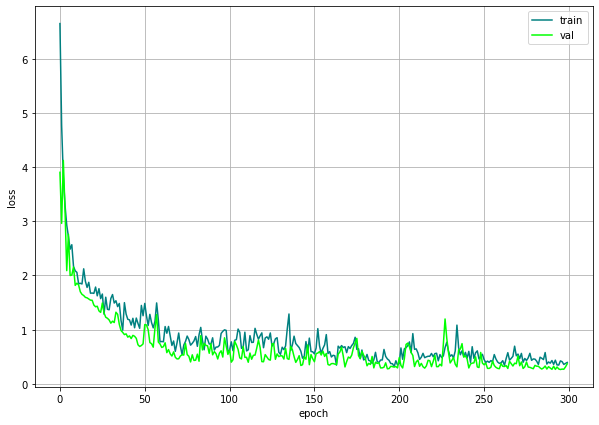

In [104]:
# training with the best parameters 
train_l = DataLoader(train_data, batch_size=20, shuffle=True, num_workers=0 )
val_l = train_l
loss = nn.MSELoss() 

# Best parameter selection
par_t = params[np.argmin([v[-1] for v in val_log])]
print("Best network parameters found are \n",par_t)

# Creating the network with the best set of parameters
Ni, Nh1, Nh2, No = 1, par_t['Nh'], 2*par_t['Nh'], 1
best_net = Net(Ni, Nh1, Nh2, No, par_t['drop']).to(par_t['device'])

# Be careful to choose the right optimizer
if par_t['optimizer']=='adam':
    opt = optim.Adam(best_net.parameters(), lr=par_t['learning_rate'], 
                     weight_decay=par_t['regularization'])
elif par_t['optimizer']=='sgd':
    opt = optim.SGD(best_net.parameters(), lr=par_t['learning_rate'], momentum=0.9,
                   weight_decay=par_t['regularization'])

# Training & validation
train_loss, val_loss = best_net.fit(train_l, val_l, opt, loss, par_t)

plt.figure(figsize = (10,7))
plt.plot(train_loss, label='train', color = "teal")
plt.plot(val_loss, label='val', color = "lime")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

It's time now to represent actually the predictions of the network trained on the training set to see whether predicted points have the same labels as the training ones, leading to overfitting.

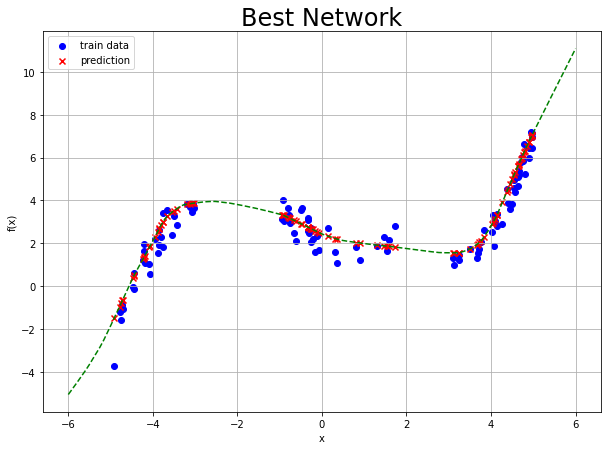

In [308]:
# starting from the dataframe read directly through pandas
x_t = torch.unsqueeze(torch.tensor(train_df.input), dim=1).float()
x = Variable(x_t).to(device)

y_t = torch.unsqueeze(torch.tensor(train_df.label), dim=1).float()
y = Variable(y_t).to(device)

# predicted points
x_pred = torch.linspace(-6, +6, 1000).to(device).unsqueeze(-1)

fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Best Network', fontsize = 24)
ax.scatter(train_df.input, train_df.label, color = 'b', label = "train data")

#feed the network with x and save the output
prediction = best_net(x)    

# Network output without tracking gradients. These are the actual predictions 
with torch.no_grad():
    y_pred = best_net(x_pred)

ax.plot(x_pred.squeeze().cpu().numpy(), y_pred.squeeze().cpu().numpy(), 'g--')
ax.scatter(x.data.cpu().numpy(), prediction.data.cpu().numpy(), color = 'r', marker = 'x', label = "prediction")
ax.set_xlabel("x")
ax.set_ylabel("f(x)")

plt.grid()
plt.legend()
plt.show()

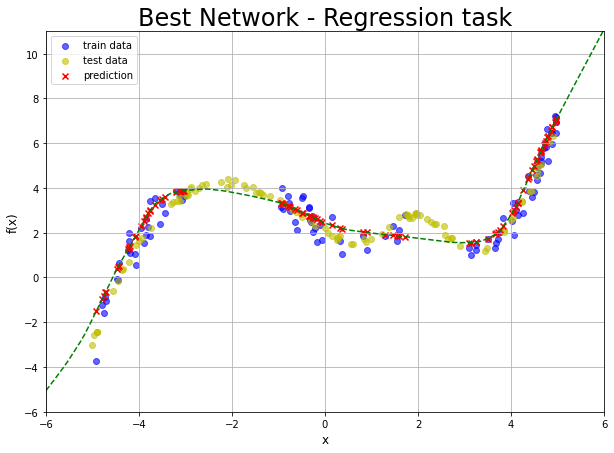

In [309]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Best Network - Regression task', fontsize = 24)
ax.set_xlabel('x'   , fontsize = 12)
ax.set_ylabel('f(x)', fontsize = 12)
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 11)
ax.scatter(train_df.input, train_df.label, color = 'b', label = "train data", alpha =.6)
ax.scatter(test_df.input, test_df.label, color = 'y', label = "test data", alpha =.6)

ax.plot(x_pred.squeeze().cpu().numpy(), y_pred.squeeze().cpu().numpy(), 'g--')
ax.scatter(x.data.cpu().numpy(), prediction.data.cpu().numpy(), color = 'r', marker = 'x', label = "prediction")

plt.grid()
plt.legend()
plt.show()

The obtained network can approximate the function in the range where training points are present while it fails in ranges $[-3,-1]$ and $[2,3]$ indeed it connects the two points with straight lines. Furthermore for $x\approx 4$ network overfits since predicts a behavior that is not present in reality.

It could be useful also to represent and analyze weights informations from the hidden layers:

In [105]:
# First hidden layer
h1_w = best_net.fc1.weight.data.cpu().numpy()
h1_b   = best_net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = best_net.fc2.weight.data.cpu().numpy()
h2_b   = best_net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = best_net.out.weight.data.cpu().numpy()
out_b   = best_net.out.bias.data.cpu().numpy()

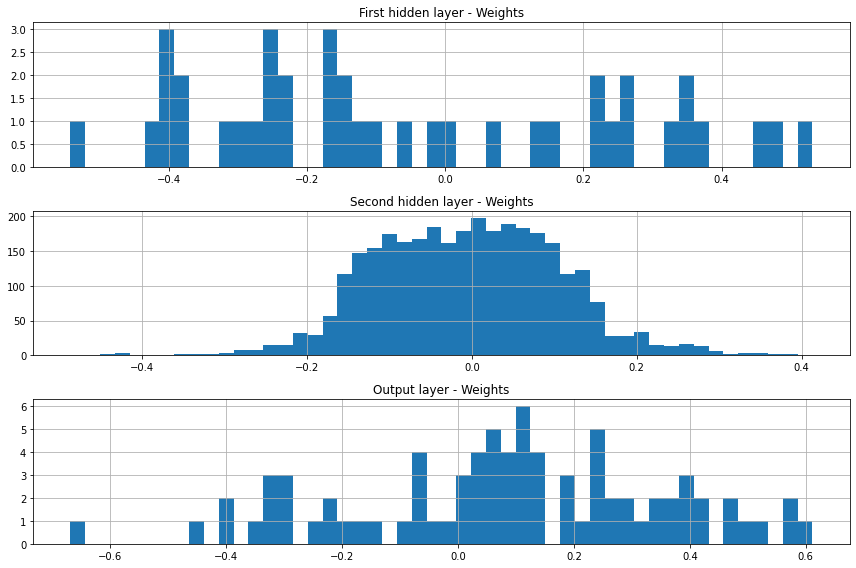

In [107]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer - Weights')

axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer - Weights')

axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer - Weights')
[ax.grid() for ax in axs]
plt.savefig('weights.png')
plt.tight_layout()
plt.show()

Weights are not exploding and they do not show any strange behavior thanks to the presence of regularization.

In [51]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

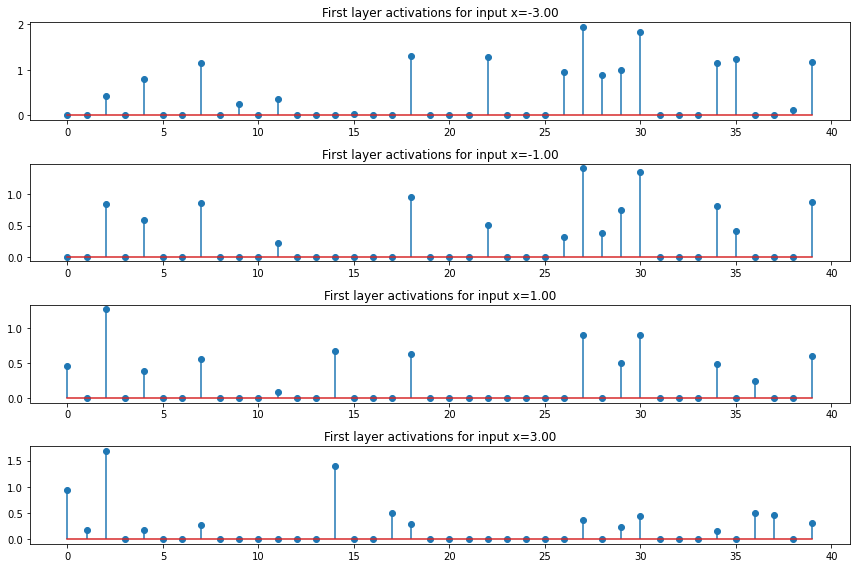

In [112]:
### Register hook  
hook1 = best_net.fc1.register_forward_hook(get_activation)

### Analyze activations
best_net.to(device).eval()
inputs = [-3, -1, 1, 3]
inputs_list = [torch.tensor([x]).float() for x in inputs]
outputs_list = []

with torch.no_grad():
    for input in inputs_list:
        temp_y = best_net(input.to(device))
        outputs_list.append(activation)

### Remove hook
hook1.remove()

### Plot activations
tot_inputs = len(inputs_list)
fig, axs = plt.subplots(tot_inputs, 1, figsize=(12,8))
for i, output in enumerate(outputs_list): 
    axs[i].stem(output.cpu().numpy(), use_line_collection=True)
    axs[i].set_title('First layer activations for input x=%.2f' % inputs[i])
plt.savefig('activations_first.png')
plt.tight_layout()
plt.show()

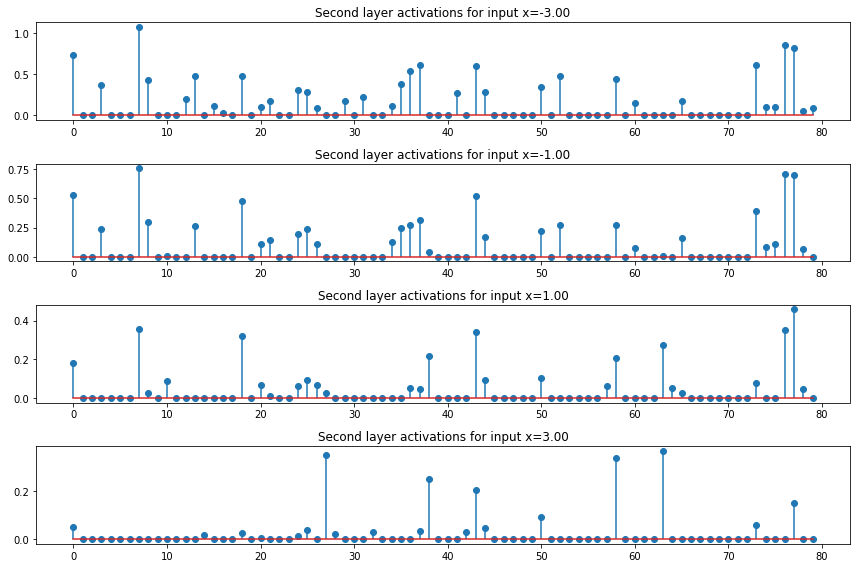

In [113]:
### Register hook  
hook_handle2 = best_net.fc2.register_forward_hook(get_activation)

### Analyze activations
best_net.to(device).eval()
inputs = [-3, -1, 1, 3]
inputs_list = [ torch.tensor([x]).float() for x in inputs]
outputs_list = []

with torch.no_grad():
    for input in inputs_list:
        temp_y = best_net(input.to(device))
        outputs_list.append(activation)

### Remove hook
hook_handle2.remove()

### Plot activations
tot_inputs = len(inputs_list)
fig, axs = plt.subplots(tot_inputs, 1, figsize=(12,8))
for i, input in enumerate(outputs_list): 
    axs[i].stem(input.cpu().numpy(), use_line_collection=True)
    axs[i].set_title('Second layer activations for input x=%.2f' % inputs[i])
plt.savefig('activations_second.png')
plt.tight_layout()
plt.show()

There are two main differences in the left part of inputs and the right part as weights activate differently for the first and second layer. While the first layer does not show a particular behavior the second one is more similar to the output of the network.

### Classification task 

In [7]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=False)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=False)

Visualization of one image 

SAMPLE AT INDEX 0
LABEL: 9


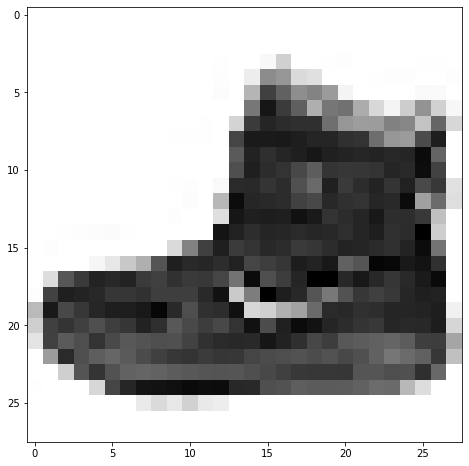

In [116]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [117]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [118]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


Classification task consists in training a convolutional neural network for classifying ten types of images with shape 28x28 pixels coming from the FashionMNIST dataset

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm
from torch.utils.data import Dataset, DataLoader, SequentialSampler, ConcatDataset
from torch.autograd import Variable
from sklearn.model_selection import KFold
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm import tqdm   
from scipy.stats import loguniform 
from IPython.display import clear_output
import json

#set seed for reproducibility
seed = 1999
np.random.seed(seed)
torch.manual_seed(seed)

# Check if a cuda GPU is available and eventually select it
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU available")
else:
  device = torch.device("cpu")
  print("GPU NOT available")

GPU available


In [14]:
class EarlyStop:
    '''
    Thanks to this class the training algorithm can be stopped when, within a certain number of epochs, accuraacy 
    does not improve anymore
    '''

    def __init__(self, wait = 3, delta = 1e-4):
        '''
        wait     : how many iterations to wait after last improvement (default: 3)
        delta    : the minimum improvement to be taken into account (default: 1e-4)
        '''

        self.wait = wait
        self.counter  = 0
        self.delta    = delta

        self.metrics_min = np.Inf
        self.early_stop  = False
        self.best_score  = None

    def __call__(self, metrics, model):
        actual_score = -metrics

        # first time step
        if self.best_score is None:
            self.best_score = actual_score 

        # When there is no improvement 
        elif actual_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.wait:
                self.early_stop = True

        # if there is improvement, restart the counter
        else:
            self.best_score = actual_score
            self.counter = 0


In [15]:
class Network(nn.Module):
    def __init__(self, n_chan = 1 , drop = 0.):
        '''
        Building a Convolutional Neural Network with 
        - 1 Convolutional layer + stride
        - 1 Convolutional layer + stride
        - Flattening
        - 1 Dense layer + Dropout 
        - 1 Dense layer (10 units) -> OUTPUT
        INPUT
         - drop (float)    : probability of dropout for the two dense layers
         - n_channels(int) : number of output channels of the first layer
        '''
        super().__init__()

        self.batch_size = n_chan
        flatten_dim = (2*n_chan)*5*5
        self.conv1 = nn.Conv2d(in_channels = 1,  out_channels = n_chan, kernel_size = 4, padding=1, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = n_chan, out_channels = 2*n_chan, kernel_size=5, stride = 2)
        self.fc1 = nn.Linear(flatten_dim, 128)
        self.out = nn.Linear(128, 10)
        self.relu  = nn.ReLU()
        self.drop = nn.Dropout(p = drop)

    def forward(self, x):

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.drop(self.fc1(x)))
        x = self.out(x)

        return x
    
    def train_epoch(self, train_data_load, loss_fn, optimizer, device):
        '''
        Train the network (self) using as input eventual batches from train_data_load,
        having chosen the loss_function and the optimizer
        it returns:
        - the mean loss over batches
        - the standard deviation loss over batches
        '''
        self.train()
        # Actual training
        train_loss = []
        for i_batch, sample_batched in enumerate(train_data_load):

            #divide the batch into values and labels
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            #Forward pass
            out = self.forward(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Backpropagation
            self.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

        # Save average train loss
        train_loss_mean = np.mean(train_loss)
        train_loss_std  = np.std(train_loss)

        return train_loss_mean, train_loss_std


    def eval_epoch(self, eval_data_load, loss_fn, optimizer, device):
        '''
        Evaulate the performance of network (self)
        using as input the validation set,
        having chosen the loss_function and the optimizer
        it returns:
        - the mean loss over batches
        - the standard deviation loss over batches
        '''

        self.eval()
        val_loss = []
        
        with torch.no_grad(): # Disable gradient tracking
            for i_batch, sample_batched in enumerate(eval_data_load):
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                #Forward pass
                out = self.forward(x_batch)

                # Compute loss
                loss = loss_fn(out, label_batch)
                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

        # Save average val loss
        val_loss_mean = np.mean(val_loss)
        val_loss_std  = np.std(val_loss)

        return val_loss_mean, val_loss_std

    #training WITH early stopping
    def fit_early_stop(self, train_data, val_data, params_dict, loss_fn,
                       early_stop_flag = True, patience = 10):
        train_loss_means = []
        val_loss_means = []

        train_loss_std = []
        val_loss_std = []

        optimizer = params_dict.get('optimizer')
        device = params_dict.get('device')
        
        #train with early stopping 
        if early_stop_flag: 
            early_stop = EarlyStop(patience)

        for epoch in tqdm(range(params_dict.get('n_epochs'))):
            loss_mean, loss_std =  self.train_epoch(train_data, loss_fn, optimizer, device)
            train_loss_means.append(loss_mean)
            train_loss_std.append(loss_std)

            loss_mean, loss_std =  self.eval_epoch(val_data, loss_fn, optimizer, device)
            val_loss_means.append(loss_mean)
            val_loss_std.append(loss_std)

            #use early stop if the flag is set to True
            if early_stop_flag:
                early_stop(loss_mean, self)
                if early_stop.early_stop:
                    print("Loss has not increased. Early stopping...")
                    break

        train_metrics = np.array([np.array(train_loss_means), np.array(train_loss_std)])
        val_metrics = np.array([np.array(val_loss_means), np.array(val_loss_std)])

        return train_metrics, val_metrics
    
    def test(self, test_loader, params_dict):
        '''
        Test the network in a classification task
        '''
        wrong_label = 0
        predictions = []
        true_labels = []

        self.eval()
        device = params_dict.get('device')
        # Disable gradient tracking
        with torch.no_grad():
            for sample_batched in test_loader:
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                out = self.forward(x_batch)
                out = out.cpu().numpy().argmax()

                predictions.append(out)
                true_labels.append(label_batch)
                
        num_samples = len(test_loader)
        temp_list = [predictions[i]-true_labels[i] for i in range(num_samples)]
        accuracy = temp_list.count(0)/num_samples
        return accuracy

    def predict(self, data_input, device):
        '''
        Compute an array of predicted labels given input data
        '''

        self.eval()
        predictions_list = []

        #disable gradient computing/tracking
        with torch.no_grad():
            for i_batch, sample_batched in enumerate(data_input):
                x_batch = sample_batched[0].to(device) 
               
                out = self.forward(x_batch)
                outputs = out.cpu().numpy().argmax()

                predictions_list.append(outputs)
        return np.array( predictions_list )

    def save_net(self, path: str):
        torch.save( self.state_dict(), path )
    
    def load_net(self, path: str):
        self.load_state_dict( torch.load(path) )

class AddGaussianNoise():
    def __init__(self, mu = 0., std = 1.):
        self.mu  = mu
        self.std = std

    def __call__(self, tensor : torch.tensor):
        perturb = torch.randn(tensor.size(), device=tensor.device) * self.std
        return tensor + perturb + self.mu

In [8]:
basic_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                    ])

In [11]:
test_dataset  = datasets.FashionMNIST('classifier_data', train=False, transform=basic_transforms, download=True)

Gauss_noise = AddGaussianNoise()
Rotation    = transforms.RandomRotation(degrees = 45)

advanced_transform = transforms.Compose([basic_transforms,
                                        transforms.RandomChoice([Gauss_noise,Rotation])
                                        ]) 

In [12]:
train_dataset_full = datasets.FashionMNIST('classifier_data', train=True,  transform = advanced_transform, download=True)

train_frac = 0.8
train_elem = len(train_dataset_full)
n_train_elem = int(train_elem*train_frac) 
n_val_elem = train_elem - n_train_elem
n_test_elem  = len(test_dataset)

print("Elements in Train set:", n_train_elem)
print("Elements in Validation set:", n_val_elem)
print("Elements in Test set:", n_test_elem)

# Prepare Training and Validation datasets
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset_full, [n_train_elem, n_val_elem])

batch_size_train = 64
batch_size_test  = 1

# Load the data into variables 
train_loaded = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle = True)
valid_loaded = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size_train, shuffle = False)
test_loaded  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,  shuffle = False)

Elements in Train set: 48000
Elements in Validation set: 12000
Elements in Test set: 10000


The training dataset is made of 60 000 samples while the test 10 000. In order to implement model validation and parameters tuning it is better to split the training set into two disjoint groups: 
- actual training set, 80% of the initial training devoted samples;
- validation set, the rest 20%.
Since the number of samples is bigger than the previous regression task, it has been chosen not to perform k-fold cross validation because the number of samples seams to be enough. <br>

In order to simplify data manipulation some transformations can be applied to the dataset like: first of all images are changed into Pytorch tensors (ToTensor() function), they are then normalized (Normalize((0.1307,), (0.3081,))()).
Data are also augmented by applying gaussian noise or by random rotations of 45 degrees. This should result into a better generalization property for the network.

##### Network architecture 

- First Convolutional Layer: with 1 channel in input, the image in grey scale, n channels as output, kernel 4x4, padding 1 and stride 2, for reducing the dimensionality of the image to 14x14. The activation function is a ReLU;
- Second Convolutional Layer: with n channels in input, $2\cdot n$ channels as output, kernel 5x5, and stride 2, for reducing the dimensionality of the image to 5x5. The activation function is the ReLU;
- Flatten Dense layer: $2\cdot n\cdot 5\cdot 5$ units;
- First hidden layer: 128 units with Relu as activation function;
- Dropout layer: connections are dropped with a probability p;
- Output layer: 10 as the unique labels of the FashionMNIST dataset.

Instead of using Pooling layers, stride parameter was used in order to diminuish the dimensionaluty of the problem, thus decreasing also the computational effort needed for the training. The loss used is the CrossEntropyLoss.
Since the computational effort is great as well as computing time it has been implemented a EarlyStop class which in case stops the network when some metrics (e.g. validation loss) does not improve for a number of iterations more than the patience parameter.

In [16]:
def get_correct_optimizer(model, params_dict):
    learn_r = params_dict.get('learn_r')
    w_dec   = params_dict.get('weight_dec')
    
    #instantiate the correct optimizer
    if params_dict.get('optimizer') == 'sgd':
        optimizer = optim.SGD(
            model.parameters(),
            lr = learn_r,
            weight_decay = w_dec,
            momentum = 0.9
            )

    elif params_dict.get('optimizer') == 'adam':
        optimizer = optim.Adam(
        model.parameters(),
        lr = learn_r,
        weight_decay = w_dec,
        )

    elif params_dict.get('optimizer') == 'adagrad':
        optimizer = optim.Adagrad(
        model.parameters(),
        lr = learn_r,
        weight_decay = w_dec
        )

    return optimizer

# reset parameters to avoid weights leakage
def reset_weights(model):
    if isinstance(model, nn.Linear):
        model.reset_parameters()

The set of hyper parameters to sample from is the following. Number of parameters is chosen to be smaller than the previous task for computational reasons. As literature states, when increasing the dimensions of a space, randomly drawing points from it is harder and less efficient. 

In [370]:
hyper_params_dic = {
    'n_chan'     : [4,8,16],
    'drop'       : np.random.uniform(0, 0.5, size = 5),
    'optimizer'  : ['sgd', 'adagrad', 'adam'],
    'learn_r'    : loguniform.rvs(1e-4, 1e-2, size =  5),
    'weight_dec' : loguniform.rvs(1e-3, 1e-1, size =  5),
    'device'     : [device]
}

#sample a single set of parameters for random search 
def sample_set_params(params):
  drawn = {}
  for param in params.keys():
    drawn[param] = np.random.choice(params.get(param))
  return drawn

sample_set_params(hyper_params_dic)

# random search is computed by this function
def CV_random_set(train, valid, params_grid, iters):
    '''
    This functions tries a given number of set of parameters, in order
    to find the optimal set of parameters which gives the minimum validation loss
    INPUTS:
    - train       : training set dataloader
    - valid       : validation set dataloader
    - params_grid : a dictionary with the parameters to sample from
    - iters       : number of set of parameters to test

    OUTPUT:
    A dictionary containing: 
    - the set of parameters chosen
    - training loss for every epoch
    - validation loss for every epoch
    '''

    output_dict = {}
    parameters_list     = []
    train_loss_log      = []
    validation_loss_log = []

    # the loss remains the same due to the nature of the problem
    loss = nn.CrossEntropyLoss()

    for iterat in range(iters):
        print("\n MODEL", iterat+1, "/", iters)

        actual_params = sample_set_params(params_grid)
        parameters_list.append(actual_params)

        n_chan = actual_params.get('n_chan')
        drop = actual_params.get('drop')
        optimizer = actual_params.get('optimizer')
        learn_r = actual_params.get('learn_r')
        weight_dec = actual_params.get('weight_dec')
        device = actual_params.get('device')

        # create new network with given parameters and reset weights
        network = Network(n_chan=n_chan, drop=drop).to(device)
        network.apply(reset_weights)

        optimizer = get_correct_optimizer(network, actual_params)

        dummy_dict = {'optimizer': optimizer, 'n_epochs': 40, 'device': device}
        train_loss, val_loss = network.fit_early_stop(train, valid, dummy_dict, loss,
                                                      early_stop_flag = True, patience = 2)
        train_loss_log.append(train_loss)
        validation_loss_log.append(val_loss)
        clear_output(wait=True)
        del network 


    return  parameters_list, train_loss_log, validation_loss_log 

In [375]:
parameters, train_loss, val_loss = CV_random_set(train_loaded, valid_loaded, hyper_params_dic, 10)


 ################ MODEL 10 / 10   ###########


 12%|█▎        | 5/40 [02:08<14:59, 25.71s/it]

Loss has not increased. Early stopping...


In [ ]:
# since train and val loss are arrays with mean and standard deviations time series for each parameters set, just the 
# first element of each of the ten arrays is needed

train_loss_means = [i[0] for i in train_loss]
val_loss_means = [i[0] for i in val_loss]

# assigning to the best set of params the sequence of val and train loss that achieves the minimum losses indeed

index_train_min = np.argmin([train_loss_means[i][-1] for i in range(10)])
index_val_min = np.argmin([val_loss_means[i][-1] for i in range(10)])

print("Best set of parameters is: ------>" )
opt_set = parameters[index_val_min]
print(opt_set)

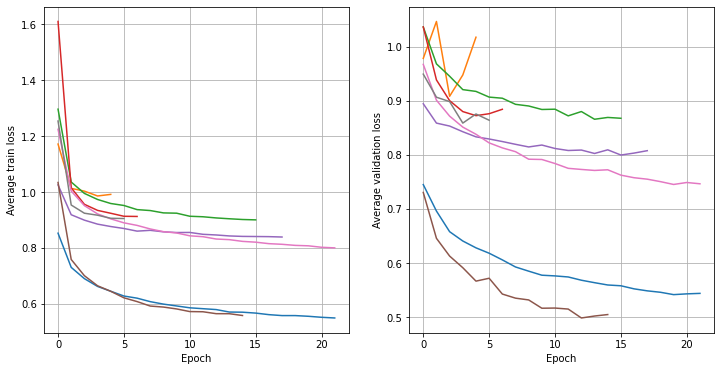

In [378]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
for i in range(2,10):
    ax[0].plot(train_loss_means[i])
    ax[1].plot(val_loss_means[i])
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Average train loss')
ax[1].set_ylabel('Average validation loss')
ax[0].grid()
ax[1].grid()
plt.show()

The best set of parameters obtained after performing the random search on ten set of parameters is:
- 'n_chan': 16, 
- 'drop': 0.028178, 
- 'optimizer': 'adam', 
- 'learn_r': 0.000881, 
- 'weight_dec': 0.002693

In [27]:
n_chan = opt_set.get('n_chan')
drop = opt_set.get('drop')
optimizer = opt_set.get('optimizer')
learn_r = opt_set.get('learn_r')
weight_dec = opt_set.get('weight_dec')
device = opt_set.get('device')

# instantiate the best network
best_net = Network(n_chan = n_chan, drop = drop).to(device)
best_net.apply(reset_weights)
optimizer = get_correct_optimizer(best_net, opt_set)
# instantiate this dummy dict due to "fit" method implementation
dummy_dict = {'optimizer': optimizer, 'n_epochs': 25, 'device': device} 
loss_function = nn.CrossEntropyLoss()

train, test = best_net.fit_early_stop(train_loaded, valid_loaded, dummy_dict, loss_function,
                                      True, 5)

 96%|█████████▌| 24/25 [08:12<00:20, 20.50s/it]

Loss has not increased. Early stopping...


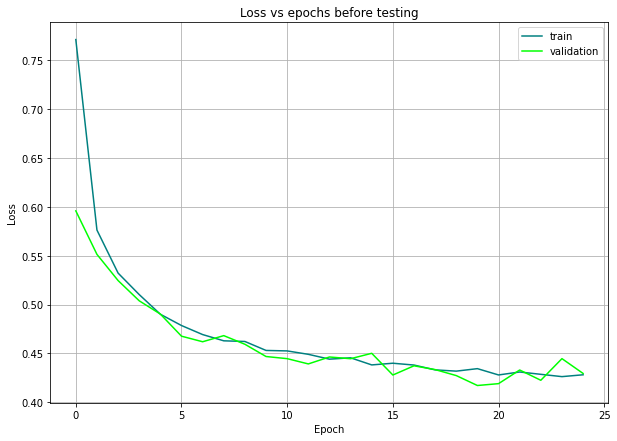

In [58]:
plt.figure(figsize = (10,7))
plt.plot(train[0,:], label = 'train', color = "teal")
plt.plot(test[0,:], label = 'validation', color = "lime")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs epochs before testing')
plt.grid()
plt.legend()
plt.show()

When training a deep neural network regularization is applied to help the model for:

Obtain higher validation/testing accuracy <br>
And ideally, to generalize better to the data outside the validation and testing sets

Regularization methods often sacrifice training accuracy to improve validation/testing accuracy — in some cases that can lead validation loss being lower than training loss.

Secondly, regularization methods such as dropout are not applied at validation/testing time, because usually dropout is activated when training but deactivated when evaluating on the validation set. For this reason the validation loss could be a bit smaller than the training since it would be a smoother function overall. 

In this particular case of the CNN model both training and validation decrease w.r.t epochs. It's possible also to see that after $\approx 22$ epochs validation error becomes larger than training meaning that probably the model is starting to overfitting. However it could be also the case of a fluctuation around the converging value of the training loss function and the early stopping did not allow the figure to show the successive behavior for the validation loss. 

Performances of the best network can be measured and depicted through a confusion matrix on the whole test set.

Simple model without optimization accuracy is:  0.8612

 Confusion matrix (normalized)


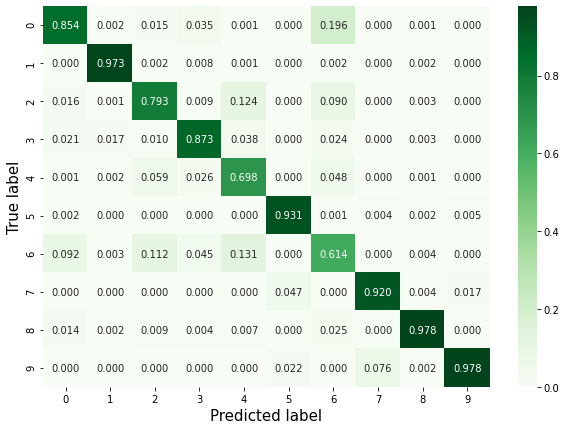

In [52]:
best_dict = {'device': device, 
             'optimizer': optim.Adam(best_net.parameters()) ,
             'n_epochs': 15
            }
print("Simple model without optimization accuracy is: ", best_net.test(test_loaded, best_dict))
# Confusion matrix for predictions
predict = best_net.predict(test_loaded, best_dict.get('device'))
true_labels = np.array([x[1] for x in test_dataset])

u, counts = np.unique(true_labels, return_counts=True)
confusion_mat = skm.confusion_matrix(predict, true_labels)

print("\n Confusion matrix (normalized)")
plt.figure(figsize = (10,7))
sns.heatmap(confusion_mat/counts[:,None], annot=True, fmt =  "1.3f" , cmap="Greens" )
plt.ylabel('True label', fontsize = 15)
plt.xlabel('Predicted label', fontsize = 15)
plt.show()

The model is able to classify clothes with an accuracy of $\approx 86\%$. It's still a valid result but the expectation for a convolutional network were higher. This outcome could be due to possible reasons:
- a small number of epochs used to train initially the network and choose the best set of parameters;
- a small number of choices for the hyperparameters sets due to high computational effort;
- a wrong separation in terms of fractions of the whole dataset into training, validation and set.  

#### Layer activations visualization

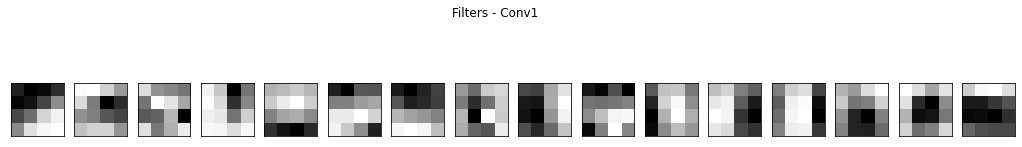

In [53]:
# First hidden layer
conv1_w = best_net.conv1.weight.data.cpu().numpy()
conv2_w = best_net.conv2.weight.data.cpu().numpy()

fig, ax = plt.subplots(1,int(opt_set['n_chan']), figsize=(18, 3))

for i in range(int(opt_set['n_chan'])):
    ax[i].imshow(conv1_w[i, 0, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.suptitle('Filters - Conv1 ', fontsize = 12)
plt.show()

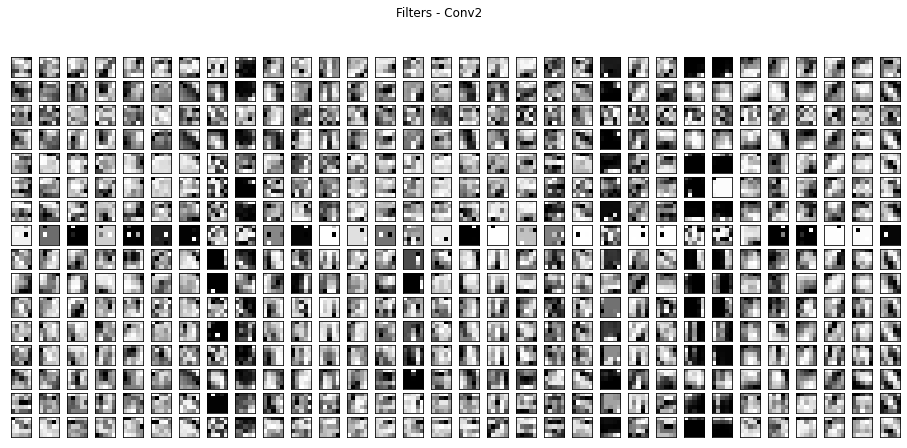

In [54]:
fig, ax = plt.subplots(int(opt_set['n_chan']), 2*int(opt_set['n_chan']), figsize=(16, 7))

for i in range(int(opt_set['n_chan'])):
    for j in range(2*int(opt_set['n_chan'])):
        ax[i,j].imshow( conv2_w[j, i, :,:], cmap='Greys')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
    
fig.suptitle('Filters - Conv2 ', fontsize = 12)
plt.savefig('filters_CL1_2.png')
plt.show()

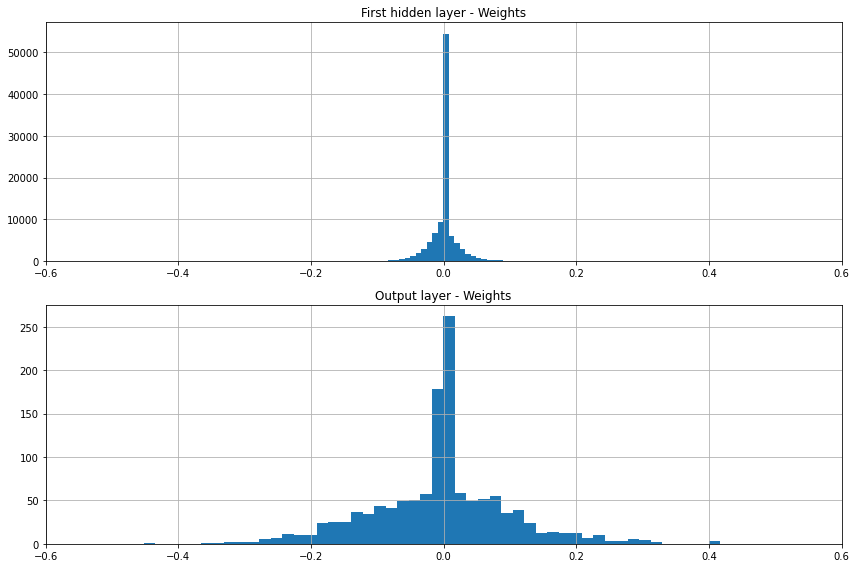

In [55]:
# First hidden layer
h1_w = best_net.fc1.weight.data.cpu().numpy()
h1_b   = best_net.fc1.bias.data.cpu().numpy()

# Second hidden layer
out_w = best_net.out.weight.data.cpu().numpy()
out_b   = best_net.out.bias.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(2, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_xlim(-0.6,0.6)
axs[0].set_title('First hidden layer - Weights')

axs[1].hist(out_w.flatten(), 50)
axs[1].set_xlim(-0.6,0.6)
axs[1].set_title('Output layer - Weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

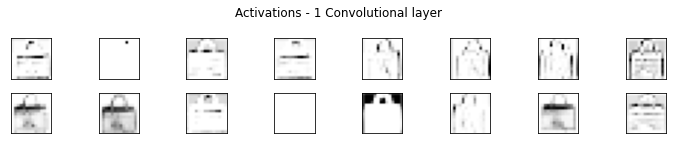

In [56]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)
    
### Register hook  
hook_h1 = best_net.conv1.register_forward_hook(get_activation)

#load a single image
image_test = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True)

### Analyze activations
best_net.to(device).eval()

with torch.no_grad():
    for s_batch in image_test:
        my_image = s_batch
        x_first = my_image[0].to(device)
        y_first = best_net(x_first)
        z_first = activation
        break

first_conv_layer_act = z_first.cpu().numpy()
hook_h1.remove()

## Plot the activations
fig, ax = plt.subplots(2, int(opt_set.get('n_chan')/2), figsize=(10,2))
for i in range(int(opt_set.get('n_chan'))):
    ax[i%2, i//2].imshow(first_conv_layer_act[0, i, :, :], cmap='Greys')
    ax[i%2, i//2].set_xticks([])
    ax[i%2, i//2].set_yticks([])

fig.suptitle('Activations - 1 Convolutional layer', fontsize = 12)    
plt.tight_layout()
plt.show()   

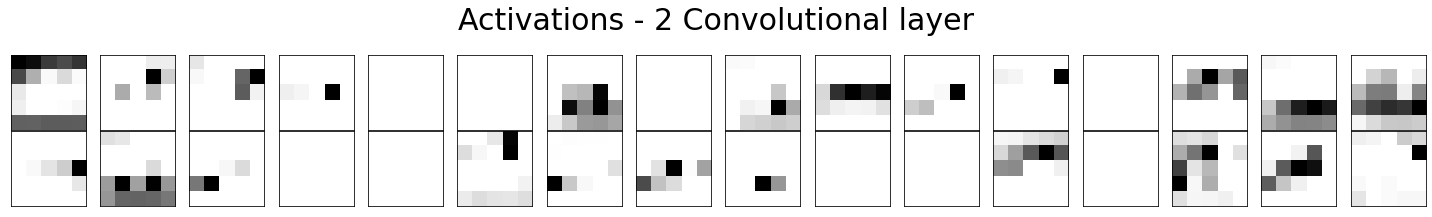

In [57]:
### Register hook  
hook_h2 = best_net.conv2.register_forward_hook(get_activation)

with torch.no_grad():
    for s_batch in image_test:
        my_image = s_batch
        x_sec = my_image[0].to(device)
        y_sec = best_net(x_sec)
        z_sec = activation
        break
        
sec_conv_layer_act = z_sec.cpu().numpy()
hook_h2.remove()

## Plot the activations
fig, ax = plt.subplots(2, int(opt_set.get('n_chan')), figsize=(20,3))
for i in range(int(2*opt_set.get('n_chan'))):
    ax[i%2, i//2].imshow( sec_conv_layer_act[0, i, :, :], cmap='Greys')
    ax[i%2, i//2].set_xticks([])
    ax[i%2, i//2].set_yticks([])

fig.suptitle('Activations - 2 Convolutional layer', fontsize = 30)    
plt.tight_layout()
plt.show()   

If one inspects the filters of the two convolutional layers it can be seen that the feature maps act really different from one another. The first convolutional layer mainly focuses on specific portions of the input image, trying to capture an overall behavior.
On the other hand, the second convolutional layer is able to learn more abstract features, and according to the filter weights it seems like it is acting as an edge detector with the edges having different shapes and orientations. 
Moreover, taking a look at the weights of the network of the fully connected and output layer, we
cannot spot any weird behavior. Indeed they are in acceptable ranges and well distributed, thus
showing that the network was properly trained and might not be suffering of overfitting.